## Lógica Computacional: 21/22## 
---
##Trabalho 1## 

$Grupo$ $7$ 

*   David José de Sousa Machado (A91665)
*   Ivo Miguel Gomes Lima (A90214)
---
#Inicialização

Para a resolução destes exercícios usamos a biblioteca [OR-Tools](https://developers.google.com/optimization) que criou uma interface para o SCIP. Esta biblioteca foi instalada com o commando `pip install ortools`.

In [2]:
!pip install ortools

In [3]:
import networkx as nx
from ortools.linear_solver import pywraplp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from tabulate import tabulate
import timeit
import random

np.set_printoptions(threshold=np.inf, linewidth=np.inf)

# Problema 2: Sudoku


 Tradicional o jogo Sudoku tem dimensoes $3 \times 3$ (corresponde ao caso $N=3$), o nosso objetivo é preencher uma grelha de $\,N^2\times N^2\,$ com inteiros positivos no intervalo $\,1$ até $\,N^2\,$, satisfazendo as seguintes regras:
     
  >Cada inteiro no intervalo $1$ até $N^2,$ocorre  só uma vez em cada coluna, linha e secção $ N\times N$.

  >No início do jogo uma fração $0<\ \alpha < 1\,$ das $N^4$ casas da grelha são preenchidas de forma consistente com a regra anterior.
    
As condições exigidas foram:
1. Um programa que inicialize a grelha a partir dos parâmetros $N$ e $\alpha$
2. Apresentação de uma solução para  as combinações de parâmetros $N\in(3,4,5,6)$  e$ \ \alpha \in (0.0,0.2,0.4,0.6) $ . Tirando ainda conclusões relativamente à complexidade computacional das mesmas.

#Implementação

#$1.$


In [ ]:
def gerar_sudoku(n, alpha):
  leng = n**2
  matrix = np.zeros((leng, leng))
  dispensable = round((1-alpha) * n**4)

  # gera sudoku correcto
  for line in range(leng):
    aux = line // n
    for col in range(leng):
      val = line*n + col + aux
      matrix[line][col] = val % leng + 1
  
  # mistura aleatoriamente
  for step in range(0, leng, n):
    for _ in range(leng):
      r1 = random.randint(0, n-1)
      r2 = random.randint(1, n-1)
      l1 = r1 + step
      l2 = (r1 + r2) % n + step

      matrix[[l1, l2]] = matrix[[l2, l1]]

  for step in range(0, leng, n):
    for _ in range(leng):
      r1 = random.randint(0, n-1)
      r2 = random.randint(1, n-1)
      c1 = r1 + step
      c2 = (r1 + r2) % n + step

      matrix[:, [c1, c2]] = matrix[:, [c2, c1]]

  solution = np.copy(matrix)

  # apagar elementos
  while dispensable > 0:
    x = random.randint(0, leng-1)
    y = random.randint(0, leng-1)
    if matrix[x, y] != 0:
      dispensable -= 1
    matrix[x, y] = 0

  return solution.astype(int).tolist(), matrix.astype(int).tolist()

In [ ]:
solved, unsolved = gerar_sudoku(3, 0)
unsolved

[[0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0]]

# 2.
Uma vez que tivemos de adotar uma estratégica lógica acabamos por pensar no Sudoku como um grafo onde cada linha\coluna apenas pode ter uma cor, ou seja transformou-se num problema de coloração de grafos.

Para o efeito criamos um grafo com $n⁴$ vértices $V$ e $ \frac{((2(n²-1)+(n-1)^2)\times n⁴)}{2}$ arestas $E$, que obedeçam às seguintes regras:   

1. $\forall_{(o,d)} \in E, \forall_{0 \le c < k} \cdot x_{o,c} + x_{d, c} \le 1$  
2. $\forall_v \in V, \sum_{0 \le c < k} \cdot x_{v,c} = 1$  

In [ ]:
def solve_color_ip(graph, k):
    solver = pywraplp.Solver.CreateSolver('BOP')

    # criar dicionario de variaveis x{i,j}
    x = {}
    for v in graph:
      x[v] = {}
      for c in range(k):
        x[v][c] = solver.BoolVar('x[%i][%i]' % (v,c))
    
    # Adicionar cores predefinidas
    for v in graph:
      if graph.nodes[v]['color'] == 0: # não tem cor
        continue
      for c in range(k):
        if (graph.nodes[v]['color']-1) == c: # tem a cor c
          solver.Add(x[v][c] == 1)
        else:
          solver.Add(x[v][c] == 0)
    
    # vertices adjacentes tem cores diferentes
    for o, d in graph.edges:
      for c in range(k):
        solver.Add(x[o][c] + x[d][c] <= 1)
    
    # cada vertice adjacente tem cores diferentes
    for v in graph:
      solver.Add(sum(x[v][c] for c in range(k)) == 1)

    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
      for v in graph:
        for c in range(k):
          if (round(x[v][c].solution_value()) == 1):
            graph.nodes[v]['color'] = c + 1
      return True
    
    return False

In [ ]:
def draw_with_colors(graph):
    nx.draw(graph, with_labels=True, node_size=1000, node_color = [graph.nodes[n]['color'] for n in graph], pos = nx.shell_layout(graph))

def draw_board(graph, leng):
  for pos, color in graph.nodes.data():
    if pos % leng == 0:
      print()
    print("{:3}".format(color['color']), end=" ")

In [ ]:
def solve_sudoku_graph(n, initial):
  leng = n**2
  tab = nx.Graph()

  tab.add_nodes_from(list(range(leng**2)))
  arestas = []

  # edges linhas
  for head in range(0, leng**2, leng):
    line = list(range(head, head+leng))
    for x in range(leng):
      arestas += [(line[x], ind) for ind in line[x+1:]]
  
  # edges colunas
  for head in range(leng):
    col = list(range(head, leng**2, leng))
    for x in range(leng):
      arestas += [(col[x], ind) for ind in col[x+1:]]
  
  # edges quadrado
  corners = []

  for i in range(n):
    corners += list(range(leng*n*i, leng*n*i+leng, n))

  for corner in corners:
    step = n*(n-1)
    elements = range(corner, corner+leng)
    quadrado = [elements[ind] + step*(ind // n) for ind in range(leng)]
    for x in range(leng):
      arestas += [(quadrado[x], ind) for ind in quadrado[x+1:]]
  
  tab.add_edges_from(arestas)
  #end
  
  tab.add_edges_from(arestas)

  for row in range(leng):
    for col in range(leng):
      tab.nodes[row*leng + col]['color'] = initial[row][col]
  
  if solve_color_ip(tab, leng):
    return tab

  return False

In [ ]:
n, alpha = 5, 0.4

solucao, tabuleiro = gerar_sudoku(n, alpha)

graph = solve_sudoku_graph(n, tabuleiro)
print(graph)
draw_board(graph, n**2)

Graph with 625 nodes and 20000 edges

 11   8  17  14  13  12   3  19  20   9  24  16  21  25  15   4   2  22   1  18  10   6   5  23   7 
  3  22  25  24  21   2  13   1   5   4   8  14   6  10  23  12  15   9  11   7  19  16  17  18  20 
  6   7  20   9  10  17  16  11  15   8  18  19   5   2  22  24  14  25  21  23   4   1  12  13   3 
 16  19  12  23  18  22   7  21  10  24  17   4   1  20   9   3   5  13   6   8  14  11  15   2  25 
  1   2   5   4  15  25  23   6  18  14  13  12  11   3   7  19  20  17  10  16  24  21  22   8   9 
 17  15  16  10  14  24  19   2  21  20  22  13  12   1  25  18   4   3  23   6   5   7   8   9  11 
 25  18  11  20  19  23   9  22   1  13   7   5   4   6   3  10  17   8   2  21  15  12  16  14  24 
 24   3   6  21   4   8  18  17  11  10  14  15  20  16   2   5  12   7  19   9  25  13  23  22   1 
 22  12   1   7   2   3   4  25   6   5   9  23  10  11   8  15  16  24  13  14  20  19  18  17  21 
  9  13   8   5  23   7  14  12  16  15  19  24  17  

A outra forma que encontramos para resolver um Sudoku de rank $N$ levou-nos a vê-lo como uma matriz tridimensional ($n² \times n² \times n²$) $Sudoku(X,Y,Z)$ em que $X$ representa a linha, $Y$ a coluna e $Z$ a cor. 

Para o efeito estabelecemos as seguintes restrições:

1. $\forall_x \in X, \forall_y \in Y \cdot \sum_{0 \le z < Z} Sudoku_{x,y,z} = 1$
2. $\forall_x \in X, \forall_z \in Z \cdot \sum_{0 \le y < Y} Sudoku_{x,y,z} = 1$
3. $\forall_y \in Y, \forall_z \in Z \cdot \sum_{0 \le x < X} Sudoku_{x,y,z} = 1$
4. $\forall_x \in X : \frac{n}{x}, \forall_y \in Y : \frac{n}{y}, \forall_{0 \le c_x < n²}, \forall_{0 \le c_y < n²} \cdot \sum_{0 \le z < Z} Sudoku_{\ x +\ c_x ,\ y+c_y ,\ z} = 1$

In [ ]:
def solve_sudoku_ip(n, board):
  leng = n**2
  solver = pywraplp.Solver.CreateSolver('BOP')

  # Criar variáveis
  sudoku = {}
  for x in range(leng):
    for y in range(leng):
      for z in range(leng):
        sudoku[x, y, z] = solver.BoolVar('sudoku[%i,%i,%i]' % (x, y, z))

  # Adicionar cores predefinidas
  for x in range(leng):
    for y in range(leng):
      if board[x][y] > 0:
        for z in range(leng):
          solver.Add(sudoku[x, y, z] == int(board[x][y] == z+1))
  
  # Cada par (x,y) só tem uma cor
  for x in range(leng):
    for y in range(leng):
      solver.Add(sum(sudoku[x, y, z] for z in range(leng)) == 1)

  
  for z in range(leng):
    # Cores diferentes nas linhas
    for x in range(leng):
      solver.Add(sum(sudoku[x, y, z] for y in range(leng)) == 1)

    # Cores diferentes nas colunas
    for y in range(leng):
      solver.Add(sum(sudoku[x, y, z] for x in range(leng)) == 1)

    # Cores diferentes nos blocos
    for corner_x in range(0, leng, n):
      for corner_y in range(0, leng, n):
        solver.Add(sum(sudoku[corner_x + x, corner_y + y, z] for x in range(n) for y in range(n)) == 1)
  

  status = solver.Solve()
  
  result = [[0] * leng for _ in range(leng)]
  if status == pywraplp.Solver.OPTIMAL:
    # colorir
    for x in range(leng):
      for y in range(leng):
        result[x][y] = sum((z + 1) * round(sudoku[x, y, z].solution_value()) for z in range(leng))

  return result

In [ ]:
n, alpha = 3, 0.2

solucao, tabuleiro = gerar_sudoku(n, alpha)

res = solve_sudoku_ip(n, tabuleiro)

print("Unsolved\n",tabulate(tabuleiro))
print("Solved\n",tabulate(res))


Unsolved
 -  -  -  -  -  -  -  -  -
0  0  1  0  0  0  0  0  9
0  8  0  0  0  0  0  0  0
0  0  0  0  9  0  0  1  0
7  6  0  8  0  0  0  0  4
4  0  0  0  0  0  9  0  0
0  0  8  0  0  0  0  0  0
0  0  3  0  8  0  0  0  0
2  0  0  0  0  0  7  0  0
0  0  0  0  0  0  0  0  0
-  -  -  -  -  -  -  -  -
Solved
 -  -  -  -  -  -  -  -  -
6  7  1  3  4  8  2  5  9
9  8  5  2  1  7  6  4  3
3  2  4  5  9  6  8  1  7
7  6  9  8  2  5  1  3  4
4  5  2  1  6  3  9  7  8
1  3  8  4  7  9  5  6  2
5  1  3  7  8  2  4  9  6
2  4  6  9  3  1  7  8  5
8  9  7  6  5  4  3  2  1
-  -  -  -  -  -  -  -  -


#Conclusão

Tirando proveito das módulos `timeit` e `matplotlib` obtivemos os resultados abaixo apresentados.

   0.0     0.2     0.4     0.6
------  ------  ------  ------
0.027   0.0268  0.0281  0.0305
0.133   0.1411  0.1528  0.1588
0.4965  0.5193  0.6802  0.586


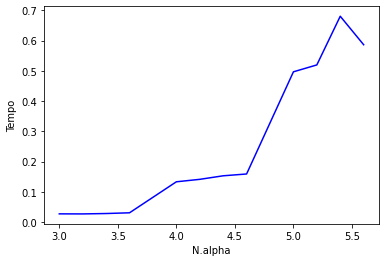

In [ ]:
alphas = [0.0, 0.2, 0.4, 0.6]
ns = list(range(3, 6))
reps = 10


x = [3.0, 3.2, 3.4, 3.6, 4.0, 4.2, 4.4, 4.6, 5.0, 5.2, 5.4, 5.6]
cube = []
graph = []

headers = ["0.0", "0.2", "0.4", "0.6"]

timestamps = np.zeros((6-3, 4))
# 
for n in range(len(ns)):
  for alpha in range(len(alphas)):
    solucao, tabuleiro = gerar_sudoku(ns[n], alphas[alpha])
    elapsed_time = timeit.timeit(lambda : solve_sudoku_ip(ns[n], tabuleiro), number=reps)
    timestamps[n, alpha] = round(elapsed_time/reps, 4)
    cube.append(timestamps[n, alpha])

print(tabulate(timestamps,headers))

# labels
plt.xlabel("N.alpha")
plt.ylabel("Tempo")

# linha cubo
plt.plot(x, cube, 'b', label='Matriz cúbica')

plt.show()

   0.0     0.2      0.4     0.6
------  ------  -------  ------
0.1485  0.147    0.1508  0.1534
1.534   1.5218   1.5337  1.5211
9.8     9.5566  11.4755  9.393


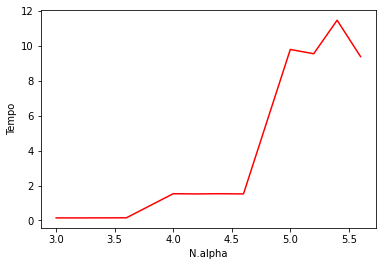

In [ ]:
for n in range(len(ns)):
  for alpha in range(len(alphas)):
    solucao, tabuleiro = gerar_sudoku(ns[n], alphas[alpha])
    elapsed_time = timeit.timeit(lambda : solve_sudoku_graph(ns[n], tabuleiro), number=reps)
    timestamps[n, alpha] = round(elapsed_time/reps, 4)
    graph.append(timestamps[n, alpha])

print(tabulate(timestamps,headers))

# labels
plt.xlabel("N.alpha")
plt.ylabel("Tempo")

# linha grafo
plt.plot(x, graph, 'r', label='Grafo')

plt.show()

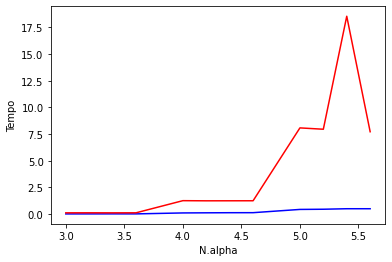

In [ ]:
# labels
plt.xlabel("N.alpha")
plt.ylabel("Tempo")


# linha cubo
plt.plot(x, cube, 'b', label='Matriz cúbica')
# linha grafo
plt.plot(x, graph, 'r', label='Grafo')

plt.show()

Para acrescentar informção aos dados recolhidos pela nossa resolução, fomos consultar alguns documentos *online* que enunciam: 
> " Um Sudoku tem uma solução válida (existir apenas uma solução para cada puzzle) se tiver no mínimo 17 células preenchidas."

No contexto do nosso problema as células preenchidos são dados pelo $\alpha$, através de alguma matemática básica entendemos que:

\begin{array}{l}
\alpha = 0.0 \rightarrow\ 0\ células\ preenchidas\\
\alpha = 0.2 \rightarrow\ \approx 16\ células\ preenchidas\\
\alpha = 0.4 \rightarrow\ \approx 32 \ células\ preenchidas\\
\alpha = 0.6 \rightarrow\ \approx 49 \ células\ preenchidas
\end{array}

O segundo fator que aumenta a dificuldade de resolver a pergunta é o número de células que têm de ser analisadas pois consome-se muito tempo a pesquisar grelhas completas, uma vez que o número de subconjuntos de cardinal 17 num conjunto com 81 (tabuleiro $3^2 \times 3^2$) elementos é igual a
\begin{align}
\frac{81!}{17!\cdot(81-17)!} = \frac{81!}{17!(64)!} = \frac{4.56873...^{31}}{3.55687...^{14}}\\
\end{align}
Mas temos de testar várias grelhas, mais precisamente
$$6\ 670\ 903\ 752\ 021\ 072\ 936\ 960 \approx 6, 7 × 10^{21} \ grelhas^{[3]}$$

Enquanto que o número de grelhas aumenta linearmente a computação de uma solução válida para o problema aumenta exponencialmente, mesmo quando é utilizada a solução lógica. 

Mesmo que não estejamos interessados na validade de um Sudoku, os cálculos acima continuam a ser relevantes para o desfecho do nosso problema. Inicialmente pensamos:
> Quanto menor o número de células preenchidas no início do problema maior será o número de comparações que o algoritmo realiza, no entanto após realizar os testes, surgiu um padrão, onde menos células preenchidas implica maior liberdade e o inverso implica mais derivações lógicas. Mas existe um ponto intermédio no qual a liberdade e as opções lógicas se anulam parcialmente.

#Referências

[1] https://www.sudokuwiki.org/Brute_Force_vs_Logical_Strategies

[2] https://pt.wikipedia.org/wiki/Sudoku

[3] http://repositorium.sdum.uminho.pt/handle/1822/21115

[4] https://ionline.sapo.pt/artigo/442988/sudoku-n-mero-minimo-de-pistas-ja-nao-e-misterio-?seccao=Mundo_i